Populating the interactive namespace from numpy and matplotlib


(array([160000.]), array([ 3.6, 12.4]), <a list of 1 Patch objects>)

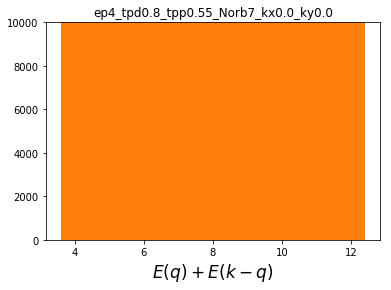

In [1]:
%pylab inline

import math
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')

from pylab import *
from hamiltonian import Parameters

M_PI = math.pi
ed = 0
ep = 4

# IMPORTANT: keep all hoppings below positive to avoid confusion
#            hopping signs are considered in dispersion separately
tpd = 0.8
tpp = 0.55
pds = 1.5
pdp = 0.7
pps = 1.0
ppp = 0.3
Norb = 7

if Norb==3:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Norb'+str(Norb)
elif Norb==7:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Norb'+str(Norb)
elif Norb==9:
    fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_Norb'+str(Norb)

def generateM(sa,sb,ca,cb):
    M = zeros((Norb,Norb))
    if Norb==3:
        # d_x2-y2 and px,py
        M = [[ed,          -2*tpd*sa*1j,       2*tpd*sb*1j],\
            [2*tpd*sa*1j,    ep,               4*tpp*sa*sb], \
            [-2*tpd*sb*1j,  4*tpp*sa*sb,       ep]] 
    elif Norb==7:
        # orbital order: dx2-y2, d3z2-r2, px, py (effectively 4-orbitals)
        # Note that there are no dxy, dxz and dyz because they do not couple to others
        # But remember that they form 3 flat bands in the finite band structure
        M = [[ed,                  0,               -2*tpd*sa*1j,           2*tpd*sb*1j],\
             [0,                  ed,               -2*tpd/sqrt(3)*sa*1j,  -2*tpd/sqrt(3)*sb*1j],\
             [2*tpd*sa*1j,  2*tpd/sqrt(3)*sa*1j,      ep,                   4*tpp*sa*sb], \
             [-2*tpd*sb*1j, 2*tpd/sqrt(3)*sb*1j,     4*tpp*sa*sb,            ep]] 
        # 7-orbtial matrix including no-hopping dxy, dxz and dyz
        M = [[ed,                  0,            0,   0,   0,   -2*tpd*sa*1j,           2*tpd*sb*1j],\
             [0,                  ed,            0,   0,   0,   -2*tpd/sqrt(3)*sa*1j,  -2*tpd/sqrt(3)*sb*1j],\
             [0,                   0,           ed,   0,   0,     0,                       0],\
             [0,                   0,            0,  ed,   0,     0,                       0],\
             [0,                   0,            0,   0,  ed,     0,                       0],\
             [2*tpd*sa*1j,  2*tpd/sqrt(3)*sa*1j, 0,   0,   0,     ep,                   4*tpp*sa*sb], \
             [-2*tpd*sb*1j, 2*tpd/sqrt(3)*sb*1j, 0,   0,   0,    4*tpp*sa*sb,            ep]] 
        M = [[ep,                   4*tpp*sa*sb], \
             [4*tpp*sa*sb,            ep]] 
    elif Norb==9:
        # orbital order: px1, px2, py1, py2, dx2-y2, d3z2-r2, dxy (effectively 7-orbitals)
        # Note that there are no dxz and dyz because they do not couple to others
        # But remember that they form 2 flat bands in the finite band structure
        tpd_x2y2  = pds/2.0*sqrt(3)
        tpd_3z2r2 = pds/2.0
        tpd_xy = pdp
        
        ex1 = 2.*tpd_x2y2 *sa*1j
        ex2 = 2.*tpd_3z2r2*sa*1j
        ex3 = 2.*tpd_xy   *sa*1j
        ey1 = 2.*tpd_x2y2 *sb*1j
        ey2 = 2.*tpd_3z2r2*sb*1j
        ey3 = 2.*tpd_xy   *sb*1j
        
        e1 = 2.*(ppp-pps)*ca*cb
        e2 = 2.*(ppp+pps)*sa*sb
        
        # Mona's matrix using her convention (signs) of py2 and dxy 
        M = [[ep,      e1,      0,      -e2,         ex1,      -ex2,        0],\
             [e1,      ep,    -e2,        0,           0,         0,     -ey3],\
             [0,      -e2,     ep,       e1,           0,         0,      ex3], \
             [-e2,      0,     e1,       ep,         ey1,       ey2,        0], \
             [-ex1,     0,      0,     -ey1,          ed,         0,        0], \
             [ex2,      0,      0,     -ey2,           0,         ed,       0], \
             [0,      ey3,    -ex3,       0,           0,         0,       ed]] 
        
        # Mi's matrix using sign convention: py2 up+ dn- and d_3z2-r2 positive sign
        # Note: if you change the sign for an orbital, then you also have to put an extra minus 
        # in any matrix element that involves that orbital with another (unchanged one);
        # whereas diagonal matrix elements stay unchanged. This is because
        # <a|H|-b> = - <a|H|b> while <-b|H|-b> = <b|H|b>
        # If you change the sign of two orbitals, then matrix element is unchanged <-a|H|-b> = <a|H|b>
        M = [[ep,      e1,      0,       e2,          ex1,       ex2,        0],\
             [e1,      ep,     e2,        0,            0,         0,     -ey3],\
             [0,       e2,     ep,       e1,            0,         0,     -ex3], \
             [e2,       0,     e1,       ep,         -ey1,       ey2,        0], \
             [-ex1,     0,      0,       ey1,          ed,         0,        0], \
             [-ex2,     0,      0,      -ey2,           0,        ed,        0], \
             [0,      ey3,    ex3,        0,            0,         0,       ed]] 
    return M

Ms = ['-b','-r','-g','-m','-k','-c','-y']
kx = M_PI/3.#/2.
ky = M_PI/5.#M_PI/2.
kx = 0.
ky = 0.
cnt = 0
Npts = 100.

# calculating G_{mn0}^{m'n'} in Eq.(39) in my writeup multiplet_problem_notes.pdf
# namely the convolution of single-hole spectra to compare with two-hole calculation
# in non-interaction limit. Because aim to calculate d-removal spectra so that
# only need to calculate Eq.(39) for m=m'=d_x2-y2 orbital

Eq_Ekq = []
for qx in np.arange(0,2.*M_PI,M_PI/Npts):
    for qy in np.arange(0,2.*M_PI,M_PI/Npts):
        sqx = sin(qx/2.0)
        sqy = sin(qy/2.0)
        skqx = sin((kx-qx)/2.0)
        skqy = sin((ky-qy)/2.0)
        if Norb==9:
            cqx  = cos(qx/2.0)
            cqy  = cos(qy/2.0)
            ckqx = cos((kx-qx)/2.0)
            ckqy = cos((ky-qy)/2.0)
        else:
            # no c and d so just choose random numbers
            cqx = 0.
            cqy = 0.
            ckqx = 0.
            ckqy = 0.
        
        Mq  = generateM(sqx, sqy, cqx, cqy)
        Mkq = generateM(skqx,skqy,ckqx,ckqy)
        
        Eq,  Vq  = eigh(Mq)
        Ekq, Vkq = eigh(Mkq)
        
        for i in range(0,len(Eq)):
            for j in range(0,len(Ekq)):
                Eq_Ekq.append(Eq[i]+Ekq[j])
        
plt.hist(Eq_Ekq, bins='auto')  # arguments are passed to np.histogram

xlabel('$E(q)+E(k-q)$',fontsize=17)
#ylabel('$E(k)$',fontsize=17)
#xlim([-5,12])
ylim([0,10000])
#xticks((0,Npts,2.*Npts,3.*Npts), (r'$\Gamma$','M','X',r'$\Gamma$'))
#text(0.45, 0.1, '(a)', fontsize=16)
title(fname+'_kx'+str(kx)+'_ky'+str(ky))
#grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
#legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
savefig("hist_"+fname+'_kx'+str(kx)+'_ky'+str(ky)+".pdf")

plt.hist(Eq_Ekq, bins='auto')